In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid
from shell.utils.oodloss import OODSeparationLoss
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

logging.basicConfig(level=logging.CRITICAL)

In [5]:
# dataset = "mnist"
dataset = "kmnist"
algo = "modular"
# algo = "monolithic"

experiment_folder = "experiment_results"
experiment_name = "vanilla_fix_bug_compute_loss_encodev2"


use_contrastive = True
num_trains_per_class = 64
seed = 0

save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)


In [6]:
def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
    cfg.sharing_strategy['sync_base'] = False
    return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

In [7]:
def plot_agg_learning_curves(fleet, ax=None, name=None, tasks=None, agent_ids=None, viz=True):
    if ax is None and viz:
        fig, ax = plt.subplots()

    if tasks is None:
        tasks = range(fleet.num_init_tasks-1, fleet.agents[0].net.num_tasks)

    dfs = []
    for agent in fleet.agents:
        if agent_ids is not None and agent.node_id not in agent_ids:
            continue
        df = agent.agent.record.df
        for task in tasks:
            task_df = df[df["train_task"] == task]
            task_df = task_df[task_df["test_task"] == str(task)]
            task_df['agent_id'] = agent.node_id
            # print(task_df)
            dfs.append(task_df)

    combined_df = pd.concat(dfs)


    agg_df = combined_df.groupby(['epoch']).agg({'test_acc': ['mean', 'std']}).reset_index()

    # Extract mean and standard deviation values
    mean_test_acc = agg_df['test_acc']['mean']
    std_test_acc = agg_df['test_acc']['std']

    if viz:
        # Plot the mean test_acc with shaded areas for standard deviation
        ax.plot(agg_df['epoch'], mean_test_acc, 
                label=name)
        plt.fill_between(agg_df['epoch'], mean_test_acc - 0.1 * std_test_acc, mean_test_acc + 0.1 * std_test_acc, alpha=0.3)

        ax.set_xlabel('Epoch')
        ax.set_ylabel('Test Accuracy')
        if name is not None:
            ax.legend();

    # compute area under the curve
    auc = np.trapz(mean_test_acc, agg_df['epoch'])
    return auc, agg_df

In [ ]:
fleet = setup_fleet(save_dir, modify_cfg=modify_cfg, parallel=False)

In [ ]:
fleet.load_records()

In [ ]:
# colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
#             "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"]

# for task in range(max_task+1):
# # for task in range(0, 5):
# # for task in range(19, 20):
#     task_df = df[df["train_task"] >= task]
#     # get task_df of only test_task == task
#     task_df = task_df[task_df["test_task"] == str(task)]
#     # smooth out the test_acc
#     # task_df["test_acc"] = task_df["test_acc"].rolling(5).mean()
#     plt.plot(task_df["time"], task_df["test_acc"], label=f"task {task}",
#              color=colors[task],)
# plt.legend();

In [ ]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
            "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"]


mean_test_acc_all_agents = []
std_test_acc_all_agents = []

for agent in fleet.agents:
    df = agent.agent.record.df
    df['time'] = df.index


# Iterate through each task
for task in range(fleet.agents[0].net.num_tasks):
    # Initialize an empty list to store the test accuracy data for this task across all agents
    test_acc_task_all_agents = []
    
    # Iterate through each agent
    for agent in fleet.agents:
        df = agent.agent.record.df
        # Filter the dataframe to get task_df for the current task for this agent
        task_df = df[df["train_task"] >= task]
        task_df = task_df[task_df["test_task"] == str(task)]
        # Extract the test accuracy data and append it to the list
        test_acc_task_all_agents.append(task_df["test_acc"].values)
    
    # Calculate the mean test accuracy for this task across all agents
    mean_test_acc_task = np.mean(test_acc_task_all_agents, axis=0)
    mean_test_acc_all_agents.append(mean_test_acc_task)


    std_test_acc_task = np.std(test_acc_task_all_agents, axis=0)
    std_test_acc_all_agents.append(std_test_acc_task)


# Plot the mean test accuracy for each task
for task, (mean_test_acc_task, std_test_acc_task) in enumerate(zip(mean_test_acc_all_agents, std_test_acc_all_agents)):
    task_df = df[df["train_task"] >= task]
    task_df = task_df[task_df["test_task"] == str(task)]
    plt.plot(task_df["time"], mean_test_acc_task, label=f"Task {task}", color=colors[task])
    # plt.fill_between(task_df["time"], mean_test_acc_task - std_test_acc_task, mean_test_acc_task + std_test_acc_task, color=colors[task], alpha=0.3)


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Time")
plt.ylabel("Test Accuracy")
plt.title("Learning Curve")
plt.show()


In [ ]:
# dataset = "mnist"
# # dataset = "kmnist"

# experiment_folder = "experiment_results"
# experiment_name = "vanilla_fix_bug_compute_loss_encodev2"


# use_contrastive = True
# num_trains_per_class = 64
# seed = 5

# save_dir1 = get_save_dir(experiment_folder, experiment_name,
#                         dataset, "modular", num_trains_per_class, use_contrastive, seed)

# save_dir2 = get_save_dir(experiment_folder, experiment_name,
#                         dataset, "monolithic", num_trains_per_class, use_contrastive, seed)
# def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
#     cfg.sharing_strategy['sync_base'] = False
#     return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

# fleet1 = setup_fleet(save_dir1, modify_cfg=modify_cfg, parallel=False)
# fleet1.load_records()

# fleet2 = setup_fleet(save_dir2, modify_cfg=modify_cfg, parallel=False)
# fleet2.load_records()

# fig, ax = plt.subplots()
# plot_agg_learning_curves(fleet1, ax, name="modular")
# plot_agg_learning_curves(fleet2, ax, name="monolithic")

In [ ]:
# dataset = "mnist"
# # dataset = "kmnist"

# experiment_folder = "experiment_results"
# experiment_name = "vanilla_fix_bug_compute_loss_encodev2"


# use_contrastive = True
# num_trains_per_class = 64
# seed = 7

# save_dir1 = get_save_dir(experiment_folder, experiment_name,
#                         dataset, "modular", num_trains_per_class, use_contrastive, seed)

# save_dir2 = get_save_dir(experiment_folder, experiment_name,
#                         dataset, "monolithic", num_trains_per_class, use_contrastive, seed)
# def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
#     cfg.sharing_strategy['sync_base'] = False
#     return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

# fleet1 = setup_fleet(save_dir1, modify_cfg=modify_cfg, parallel=False)
# fleet1.load_records()

# fleet2 = setup_fleet(save_dir2, modify_cfg=modify_cfg, parallel=False)
# fleet2.load_records()

# fig, ax = plt.subplots()
# plot_agg_learning_curves(fleet1, ax, name="modular")
# plot_agg_learning_curves(fleet2, ax, name="monolithic")

In [22]:
# dataset = "mnist"
# dataset = "kmnist"

datasets = ["mnist", "kmnist", "fashionmnist"]
# datasets = ["kmnist"]

experiment_folder = "experiment_results"
base_experiment_name = "vanilla_fix_bug_compute_loss_encodev2"


use_contrastive = True
num_trains_per_class = 64

viz = False
# seeds = [0, 1, 2, 3, 4, 5, 6, 7]
# seeds = [1, 2, 3, 4, 5, 6, 7]
seeds = [1, 2]

# seeds = [1]


# tasks = [3]
# agent_ids = [1]
tasks = None
agent_ids = None
ax=None
# seed = 0
sync_bases = [True, False]
opt_with_randoms = [False]

dataset_seed_aucs = {}
dataset_agg_dfs = {}
for dataset in datasets:
    seed_aucs = {}
    agg_dfs = []
    for seed in seeds:
        save_dir1 = get_save_dir(experiment_folder, base_experiment_name,
                                dataset, "modular", num_trains_per_class, use_contrastive, seed)


        # sync_bases = [True]
        # opt_with_randoms = [False]

        def modify_cfg(net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg):
            if "sync_base" not in cfg.sharing_strategy:
                cfg.sharing_strategy['sync_base'] = False
            return net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg

        fleets = {}
        fleet = setup_fleet(save_dir1, modify_cfg=modify_cfg, parallel=False)
        fleet.load_records()
        fleets['base'] = fleet
        # print("SAVE_DIR1", save_dir1)
        # print("!!!!BASE", fleets['base'].agents[0].save_dir)


        for sync_base in sync_bases:
            for opt_with_random in opt_with_randoms:
                experiment_name = f"modmod_test_sync_base_{sync_base}_opt_with_random_{opt_with_random}"
                save_dir2 = get_save_dir(experiment_folder, experiment_name,
                                        dataset, "modular", num_trains_per_class, use_contrastive, seed)
                fleet = setup_fleet(save_dir2, modify_cfg=modify_cfg, parallel=False)
                fleet.load_records()
                fleets[f'sync_base {sync_base}, rand {opt_with_random}'] = fleet

        if viz:
            fig, ax = plt.subplots()

        aucs = {}
        for title_name, fleet in fleets.items():
            aucs[title_name], agg_df = plot_agg_learning_curves(fleet, ax, name=title_name, tasks=tasks, agent_ids=agent_ids, viz=viz)
            agg_df['seed'] = seed
            agg_df['name'] = title_name
            # aucs[name] = plot_agg_learning_curves(fleet, ax, name=name, tasks=tasks, agent_ids=agent_ids, viz=False)
            agg_dfs.append(agg_df)

        combined_agg_df = pd.concat(agg_dfs)
        seed_aucs[seed] = aucs
    
    dataset_seed_aucs[dataset] = seed_aucs
    dataset_agg_dfs[dataset] = combined_agg_df

{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 1, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}
i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_

In [23]:
def plot_agg_over_seeds(combined_agg_df, title_name=None, ax=None):
    if title_name is None:
        title_name ='Aggregated Test Accuracy Learning Curves Across All Seeds and Algorithms'
    if ax is None:
        fig, ax = plt.subplots()
    agg_over_seed_name = combined_agg_df.groupby(['name', 'epoch']).agg({('test_acc', 'mean'): 'mean', ('test_acc', 'std'): 'std'}).reset_index()

    for name, group in agg_over_seed_name.groupby('name'):
        mean_test_acc = group['test_acc']['mean']
        std_test_acc = group['test_acc']['std']
        ax.plot(group['epoch'], mean_test_acc, label=name)
        ax.fill_between(group['epoch'], mean_test_acc - 0.5 * std_test_acc, mean_test_acc + 0.5 * std_test_acc, alpha=0.3)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Test Accuracy')
    ax.legend()
    ax.set_title(title_name)

In [32]:
def plot_learning_curve_bars(seed_aucs, title_name=None, ax=None):
    if title_name is None:
        title_name = 'Aggregated AUC'
    
    if ax is None:
        fig, ax = plt.subplots()

    # Initialize a dictionary to hold aggregated stats
    algo_stats = {}

    # Iterate through each seed and algorithm AUC score
    for seed, auc in seed_aucs.items():
        for algo, auc_ in auc.items():
            # Ignore bad values
            if auc_ <= 0.5:
                continue
            
            # If the algorithm is not yet in the stats dictionary, initialize it
            if algo not in algo_stats:
                algo_stats[algo] = {'total_auc': 0, 'count': 0}
            
            # Accumulate the AUC score and increment the count
            algo_stats[algo]['total_auc'] += auc_
            algo_stats[algo]['count'] += 1

    # Calculate the average AUC for each algorithm
    for algo, stats in algo_stats.items():
        average_auc = stats['total_auc'] / stats['count'] if stats['count'] > 0 else 0
        print(f"{algo}: Average AUC = {average_auc:.2f}")

    # Sort the algo_stats dictionary by average AUC in descending order
    sorted_algo_stats = sorted(algo_stats.items(), key=lambda x: x[1]['total_auc'], reverse=True)

    # Plot the bars in descending order of average AUC
    for algo, stats in sorted_algo_stats:
        average_auc = stats['total_auc'] / stats['count'] if stats['count'] > 0 else 0
        ax.bar(algo, average_auc)

    ax.tick_params(axis='x', rotation=45)  # Rotate labels
    ax.set_xticklabels(ax.get_xticklabels(), ha="right")  # Align labels to the right

    ax.set_title(title_name)


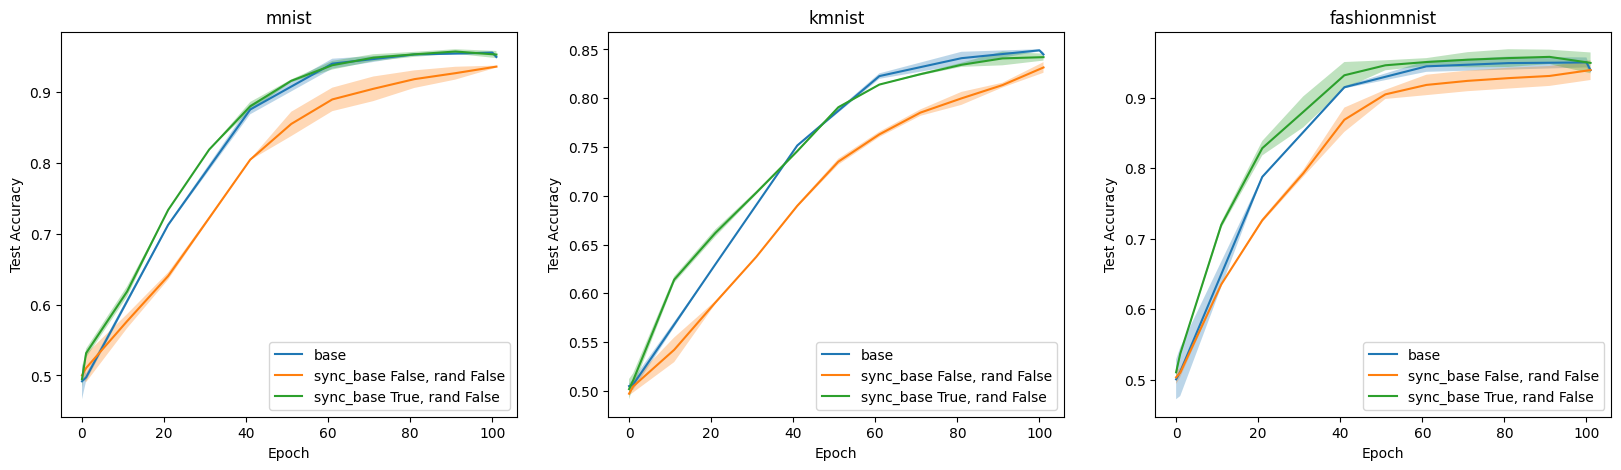

In [25]:
fig, ax = plt.subplots(1, len(dataset_agg_dfs.keys()), figsize=(20, 5))
for i, (dataset, agg_df) in enumerate(dataset_agg_dfs.items()):
    plot_agg_over_seeds(agg_df, title_name=dataset, ax=ax[i])



 mnist
base: Average AUC = 84.65
sync_base True, rand False: Average AUC = 85.58
sync_base False, rand False: Average AUC = 80.13


 kmnist
base: Average AUC = 74.96
sync_base True, rand False: Average AUC = 75.56
sync_base False, rand False: Average AUC = 70.74


 fashionmnist
base: Average AUC = 87.05
sync_base True, rand False: Average AUC = 89.22
sync_base False, rand False: Average AUC = 84.05


/tmp/ipykernel_59857/3656928494.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), ha="right")  # Align labels to the right


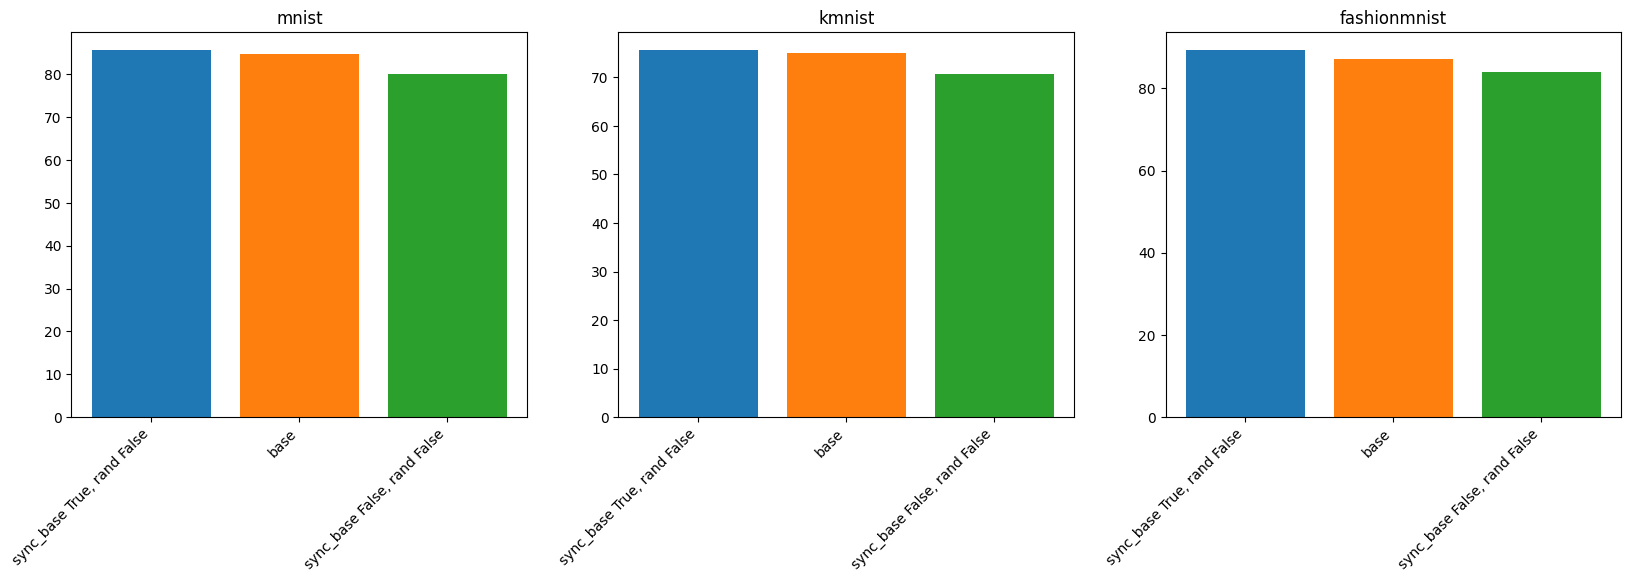

In [33]:
fig, ax = plt.subplots(1, len(dataset_seed_aucs.keys()), figsize=(20, 5))
for i, (dataset, seed_aucs) in enumerate(dataset_seed_aucs.items()):
    print('\n\n', dataset)
    plot_learning_curve_bars(seed_aucs, title_name=dataset, ax=ax[i])